In [2]:
!pip install -U pip setuptools wheel
!pip install nfl_data_py pandas==2.1.4 numpy matplotlib

In [3]:
import nfl_data_py as nfl
import pandas as pd
print("NFL data py loaded ✅")
print("Pandas version:", pd.__version__)

NFL data py loaded ✅
Pandas version: 2.1.4


In [4]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [5]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [6]:
!pip install cartopy
import cartopy

2024 done.
Downcasting floats.
Loaded team stats:


,Team,turnovers,penalty_yards,third_down_att,third_down_conv,redzone_plays,redzone_tds,third_down_pct,redzone_td_pct
0,ARI,20,876.0,211,91,236,32,0.431280,0.135593
1,ATL,25,895.0,231,94,226,29,0.406926,0.128319
2,BAL,14,886.0,233,114,271,55,0.489270,0.202952
3,BUF,9,1115.0,271,118,347,55,0.435424,0.158501
4,CAR,23,886.0,238,82,230,31,0.344538,0.134783



🏈 CWD Weekly Callouts
----------------------
🧠 Most Clear Team: BAL (81.4)
😬 Most Chaotic Team: CLE (5.3)


,Team,ClarityKickoffScore,turnovers,penalty_yards,redzone_td_pct,third_down_pct,Flag,Rank
0,BAL,81.377368,14,886.0,0.202952,0.489270,✅ Green Flag,1
1,DET,66.689739,20,703.0,0.158358,0.458874,✅ Green Flag,2
2,BUF,63.542884,9,1115.0,0.158501,0.435424,✅ Green Flag,3
3,LAC,59.424618,12,788.0,0.118943,0.395161,✅ Green Flag,4
4,DEN,56.868743,20,672.0,0.149378,0.364706,✅ Green Flag,5
5,WAS,53.823372,18,997.0,0.144044,0.456140,✅ Green Flag,6
6,TB,53.025652,26,993.0,0.171533,0.500000,✅ Green Flag,7
7,CIN,52.578167,21,804.0,0.127451,0.446809,✅ Green Flag,8
8,PHI,52.348883,15,943.0,0.129380,0.407895,⚠️ Yellow Flag,9
9,ARI,51.522265,20,876.0,0.135593,0.431280,⚠️ Yellow Flag,10


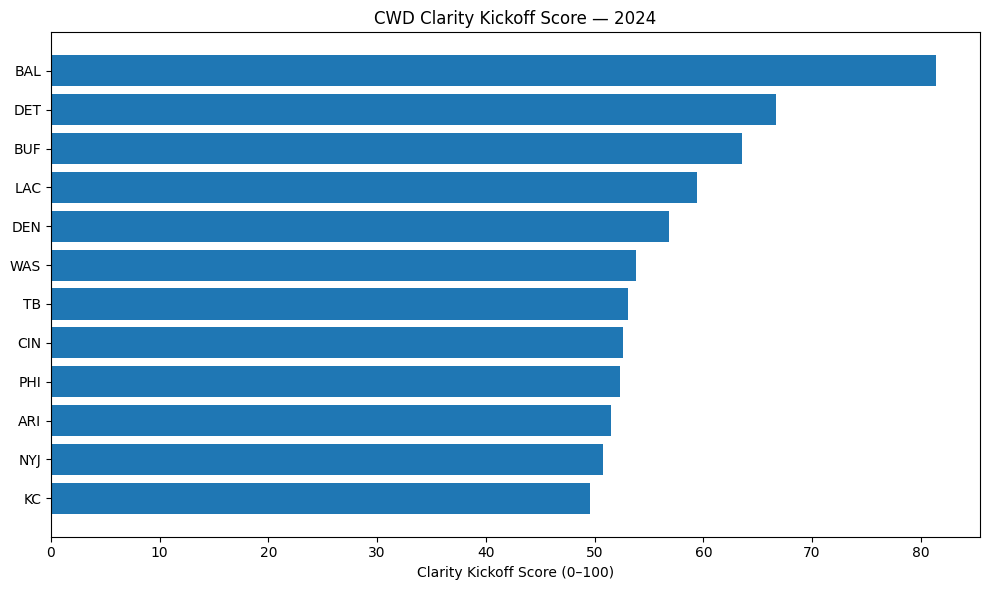


Saved: cwd_clarity_kickoff_score_2024.csv


In [8]:
# ============================
# CWD "Clarity Kickoff Score"
# Robust (PBP → Team Aggregates)
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl

# ----------------------------
# 1) Settings
# ----------------------------
SEASON = 2024
TOP_N = 12

WEIGHTS = {
    "turnovers": 0.35,     # chaos (bad) -> inverted
    "penalties": 0.20,     # chaos (bad) -> inverted
    "redzone": 0.25,       # clarity (good)
    "third_down": 0.20,    # clarity (good)
}

# ----------------------------
# 2) Load play-by-play data
# ----------------------------
pbp = nfl.import_pbp_data([SEASON])
pbp = pbp[pbp["posteam"].notna()].copy()

# ----------------------------
# 3) Build team-level metrics
# ----------------------------

# Turnovers (INT + fumble lost)
pbp["turnover_event"] = (
    (pbp["interception"].fillna(0) == 1) |
    (pbp["fumble_lost"].fillna(0) == 1)
).astype(int)

# Penalty yards (accepted)
pbp["penalty_yards_clean"] = pbp["penalty_yards"].fillna(0)

# Third down attempts / conversions
pbp["third_down_att"] = (pbp["down"] == 3).astype(int)
pbp["third_down_conv"] = ((pbp["down"] == 3) & (pbp["first_down"] == 1)).astype(int)

# Red zone plays / TDs (inside opponent 20)
pbp["redzone_play"] = (pbp["yardline_100"] <= 20).astype(int)
pbp["redzone_td"] = ((pbp["yardline_100"] <= 20) & (pbp["touchdown"] == 1)).astype(int)

team_stats = (
    pbp.groupby("posteam", as_index=False)
       .agg(
           turnovers=("turnover_event", "sum"),
           penalty_yards=("penalty_yards_clean", "sum"),
           third_down_att=("third_down_att", "sum"),
           third_down_conv=("third_down_conv", "sum"),
           redzone_plays=("redzone_play", "sum"),
           redzone_tds=("redzone_td", "sum"),
       )
)

team_stats["third_down_pct"] = np.where(
    team_stats["third_down_att"] > 0,
    team_stats["third_down_conv"] / team_stats["third_down_att"],
    np.nan
)

team_stats["redzone_td_pct"] = np.where(
    team_stats["redzone_plays"] > 0,
    team_stats["redzone_tds"] / team_stats["redzone_plays"],
    np.nan
)

team_stats = team_stats.rename(columns={"posteam": "Team"})

print("Loaded team stats:")
display(team_stats.head())

# ----------------------------
# 4) Normalize + Score
# ----------------------------
def minmax(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

team_stats["turnovers_norm"] = 1 - minmax(team_stats["turnovers"])
team_stats["penalties_norm"] = 1 - minmax(team_stats["penalty_yards"])
team_stats["redzone_norm"] = minmax(team_stats["redzone_td_pct"])
team_stats["third_down_norm"] = minmax(team_stats["third_down_pct"])

team_stats["ClarityKickoffScore"] = 100 * (
    WEIGHTS["turnovers"] * team_stats["turnovers_norm"] +
    WEIGHTS["penalties"] * team_stats["penalties_norm"] +
    WEIGHTS["redzone"] * team_stats["redzone_norm"] +
    WEIGHTS["third_down"] * team_stats["third_down_norm"]
)

out = team_stats[
    ["Team", "ClarityKickoffScore",
     "turnovers", "penalty_yards",
     "redzone_td_pct", "third_down_pct"]
].sort_values("ClarityKickoffScore", ascending=False).reset_index(drop=True)

# ----------------------------
# 5) Flags + Rank
# ----------------------------
p25 = out["ClarityKickoffScore"].quantile(0.25)
p75 = out["ClarityKickoffScore"].quantile(0.75)

def flag(x):
    if x >= p75:
        return "✅ Green Flag"
    elif x <= p25:
        return "🚩 Red Flag"
    else:
        return "⚠️ Yellow Flag"

out["Flag"] = out["ClarityKickoffScore"].apply(flag)
out["Rank"] = out["ClarityKickoffScore"].rank(ascending=False, method="min").astype(int)

# ----------------------------
# 6) Weekly Callouts
# ----------------------------
print("\n🏈 CWD Weekly Callouts")
print("----------------------")
print(f"🧠 Most Clear Team: {out.iloc[0]['Team']} ({out.iloc[0]['ClarityKickoffScore']:.1f})")
print(f"😬 Most Chaotic Team: {out.iloc[-1]['Team']} ({out.iloc[-1]['ClarityKickoffScore']:.1f})")

display(out.head(20))

# ----------------------------
# 7) Visualization
# ----------------------------
top = out.head(TOP_N).iloc[::-1]

plt.figure(figsize=(10,6))
plt.barh(top["Team"], top["ClarityKickoffScore"])
plt.xlabel("Clarity Kickoff Score (0–100)")
plt.title(f"CWD Clarity Kickoff Score — {SEASON}")
plt.tight_layout()
plt.show()

# ----------------------------
# 8) Export
# ----------------------------
csv_path = f"cwd_clarity_kickoff_score_{SEASON}.csv"
out.to_csv(csv_path, index=False)
print(f"\nSaved: {csv_path}")